# 1. Import

In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import shutil

In [2]:
def check_frame(video_path: str):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Cannot open camera")

    print(f"FPS: {int(cap.get(cv2.CAP_PROP_FPS))}")
    print(f"Frame per video: {int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

    cap.release()
    cv2.destroyAllWindows()

In [3]:
df_sports = pd.read_csv("../full_metadata_sports.csv")

df_sports

,video_name,action_idx,category,frames,resize,source_video,split,action,new_split
0,01_0001_v_-hyYa8ijq-8_c001.mp4,1,aerobic_gymnastics,31,False,v_-hyYa8ijq-8_c001.mp4,train,explosive push up,train
1,01_0002_v_-hyYa8ijq-8_c001.mp4,1,aerobic_gymnastics,31,True,v_-hyYa8ijq-8_c001.mp4,train,explosive push up,train
2,01_0003_v_-hyYa8ijq-8_c001.mp4,1,aerobic_gymnastics,32,False,v_-hyYa8ijq-8_c001.mp4,train,explosive push up,train
3,05_0001_v_-hyYa8ijq-8_c001.mp4,5,aerobic_gymnastics,89,False,v_-hyYa8ijq-8_c001.mp4,train,support,train
4,05_0002_v_-hyYa8ijq-8_c001.mp4,5,aerobic_gymnastics,87,False,v_-hyYa8ijq-8_c001.mp4,train,support,train
...,...,...,...,...,...,...,...,...,...
41892,mGRum47TLX0_00040.mp4,47,diving,57,True,mGRum47TLX0_00040.mp4,test,Reverse Dive NoTwis TUCK,val
41893,mGRum47TLX0_00044.mp4,47,diving,113,True,mGRum47TLX0_00044.mp4,test,Reverse Dive NoTwis TUCK,test
41894,ovWCmIMMkRI_00050.mp4,47,diving,109,True,ovWCmIMMkRI_00050.mp4,test,Reverse Dive NoTwis TUCK,val
41895,ovWCmIMMkRI_00051.mp4,47,diving,126,True,ovWCmIMMkRI_00051.mp4,test,Reverse Dive NoTwis TUCK,test


# 2. Interpolation of missing frames

In [5]:
def interpolated_video(df: pd.DataFrame, FRAMES: int, PRINT: False) -> pd.DataFrame:

    df['frames_new'] = df['frames']
    errors_list = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):

        category = row['category']
        split = row['new_split']
        file_name = row['video_name']

        source_path = os.path.join(f"../datasets_raw/{category}/{split}", file_name)
        destination_path = os.path.join(f"../datasets/{category}/{split}", file_name)


        if row['frames_new'] < FRAMES:
            if PRINT:
                print(f"Dodaj klatki: {FRAMES - row['frames_new']}")
            
            if PRINT:
                print(file_name)

            cap = cv2.VideoCapture(source_path)

            if PRINT:
                print(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            fps = int(cap.get(cv2.CAP_PROP_FPS))
            frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            out = cv2.VideoWriter(destination_path, fourcc, fps, frame_size)

            frames_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

            total_interpolated_frames = int(FRAMES - frames_count)

            if PRINT:
                print(total_interpolated_frames)

            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
                
            try:
                interpolated_frames_per_pair = total_interpolated_frames // (len(frames) - 1)
                if interpolated_frames_per_pair * (len(frames) - 1) + len(frames) < FRAMES:
                    interpolated_frames_per_pair += 1
            except:
                print(file_name,category,split,"Liczba klatek po wczytaniu źródła: 1")
                errors_list.append([file_name,category,split,"Liczba klatek po wczytaniu źródła: 1"])
                
            if PRINT:
                print(interpolated_frames_per_pair)

            for i in range(len(frames) - 1):
                start_frame = frames[i]
                end_frame = frames[i + 1]
                
                out.write(start_frame)
                
                for j in range(interpolated_frames_per_pair):
                    alpha = (j + 1) / (interpolated_frames_per_pair + 1)
                    interpolated_frame = np.uint8((1 - alpha) * start_frame + alpha * end_frame)
                    out.write(interpolated_frame)
                
            # Zapisanie ostatniej klatki
            try:
                out.write(frames[-1])
            except:
                print(file_name,category,split)
                errors_list.append([file_name,category,split,"Uszkodzony plik"])

            cap.release()
            out.release()

            cap_2 = cv2.VideoCapture(destination_path)

            out_frames = int(cap_2.get(cv2.CAP_PROP_FRAME_COUNT))

            cap_2.release()

            if PRINT:
                print(out_frames)

            df.loc[df[df["video_name"] == file_name].index, 'frames_new'] = out_frames
        
        else:
            shutil.copy(source_path, destination_path)

    return df, errors_list

In [6]:
df_sports_2, err = interpolated_video(df_sports,FRAMES=32, PRINT=False)

100%|██████████| 41897/41897 [15:34<00:00, 44.82it/s]  


In [7]:
df_sports_2.to_csv('../sports_metadata.csv',index=False)

del df_sports_2

df_sports_2 = pd.read_csv('../sports_metadata.csv')

<Axes: xlabel='frames_new'>

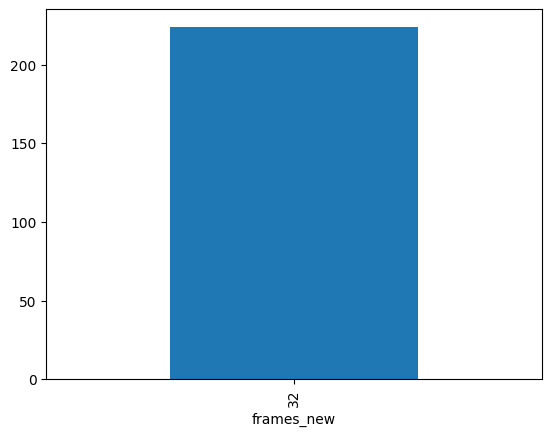

In [9]:
df_sports_2[df_sports_2['frames_new'] < 33]['frames_new'].value_counts().sort_index().plot(kind='bar')


# 3. Detection of errors in data 28.03

In [33]:
df_error = pd.DataFrame(err, columns=['video_name','category','split','error'])
df_error = df_error.sort_values(by='error')

df_error

,video_name,category,split,error
18,22_0001_v_4-EmEtrturE_c009.mp4,volleyball,train,Liczba klatek po wczytaniu źródła: 1
2,48_0003_v_JbiWR0AWKys_c005.mp4,basketball,train,Liczba klatek po wczytaniu źródła: 1
15,39_0004_v_kEyqyYJhIIg_c003.mp4,football,train,Liczba klatek po wczytaniu źródła: 1
4,48_0003_v_kguAFIlDI4E_c011.mp4,basketball,val,Liczba klatek po wczytaniu źródła: 1
5,48_0007_v_rYquruzj9hc_c001.mp4,basketball,train,Liczba klatek po wczytaniu źródła: 1
14,39_0003_v_kEyqyYJhIIg_c003.mp4,football,train,Liczba klatek po wczytaniu źródła: 1
13,39_0006_v_ITo3sCnpw_k_c012.mp4,football,test,Liczba klatek po wczytaniu źródła: 1
8,39_0003_v_07uuHJ9yXBw_c022.mp4,football,val,Liczba klatek po wczytaniu źródła: 1
17,37_0001_v_UAbX7wld9vg_c006.mp4,football,train,Liczba klatek po wczytaniu źródła: 1
10,35_0005_v_0mcffpH2VTw_c028.mp4,football,train,Liczba klatek po wczytaniu źródła: 1


In [43]:
len(df_error)

19

In [20]:
check_frame("../datasets_raw/basketball/val/48_0003_v_kguAFIlDI4E_c011.mp4")

FPS: 25
Frame per video: 1


In [38]:
df_sports_2[df_sports_2['video_name'].isin(df_error[df_error['error'] == "Liczba klatek po wczytaniu źródła: 1"].video_name)]

,video_name,action_idx,category,frames,resize,source_video,split,action,new_split,frames_new
10424,48_0003_v_JbiWR0AWKys_c005.mp4,48,basketball,8,False,v_JbiWR0AWKys_c005.mp4,train,pass,train,1
10832,48_0003_v_kguAFIlDI4E_c011.mp4,48,basketball,6,False,v_kguAFIlDI4E_c011.mp4,test,pass,val,1
11237,48_0007_v_rYquruzj9hc_c001.mp4,48,basketball,3,False,v_rYquruzj9hc_c001.mp4,train,pass,train,1
12181,39_0003_v_07uuHJ9yXBw_c022.mp4,39,football,6,False,v_07uuHJ9yXBw_c022.mp4,test,trap,val,1
12538,35_0005_v_0mcffpH2VTw_c028.mp4,35,football,8,False,v_0mcffpH2VTw_c028.mp4,train,short pass,train,1
15451,39_0003_v_bzgW-jpfuNA_c002.mp4,39,football,8,False,v_bzgW-jpfuNA_c002.mp4,train,trap,train,1
18610,39_0006_v_ITo3sCnpw_k_c012.mp4,39,football,11,False,v_ITo3sCnpw_k_c012.mp4,test,trap,test,1
18955,39_0003_v_kEyqyYJhIIg_c003.mp4,39,football,16,False,v_kEyqyYJhIIg_c003.mp4,train,trap,train,1
18956,39_0004_v_kEyqyYJhIIg_c003.mp4,39,football,11,False,v_kEyqyYJhIIg_c003.mp4,train,trap,train,1
19708,37_0001_v_UAbX7wld9vg_c006.mp4,37,football,22,False,v_UAbX7wld9vg_c006.mp4,train,cross,train,1


In [39]:
df_sports_2[df_sports_2['category'] == 'basketball']['action'].value_counts()

action
pass                       1904
dribble                    1387
interfere shot              488
2-point shot                477
drive                       324
screen                      313
pick-and-roll defensive     285
defensive rebound           226
sag                         225
3-point shot                210
pass-inbound                159
offensive rebound            62
free throw                   50
pass steal                   45
block                        30
dribble steal                29
jump ball                    18
save                          5
Name: count, dtype: int64

In [40]:
df_sports_2[df_sports_2['category'] == 'football']['action'].value_counts()

action
short pass      2406
trap            2034
press            647
dribble          587
tackle           467
steal            348
clearance        281
long pass        241
shoot            225
aerial duels     221
cross            219
diving           163
through pass     158
block            156
throw             83
Name: count, dtype: int64

In [41]:
df_sports_2[df_sports_2['category'] == 'volleyball']['action'].value_counts()

action
block                  1463
spike                   674
second pass             661
defend                  545
serve                   520
first pass              489
adjust                  157
dink                    114
protect                  71
no offensive attack      66
save                     52
second attack            26
Name: count, dtype: int64